In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
from plotnine import *
np.random.seed(12345)
from statsmodels.base.model import GenericLikelihoodModel

In [2]:
!pip3 install plotnine


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Задание 1:

##### Загрузите данные об одобрении кредитов в США.

1. Какая переменная имеет наибольшее влияние (по модулю) на одобрение займа?
2. Интерпретируйте эффект переменной loanprc на одобрение займа
3. Перечислите переменные, эффект которых значим при α = 0.001, двусторонний тест.
4. Используя подход log-odds, проиллюстрируйте эффект переменной obrat на вероятность одобрения займа.
5. Используя подход endpoint transformation, проиллюстрируйте эффект переменной obrat на вероятность одобрения займа.
6. Уберите переменную white из модели и протестируйте нулевую гипотезу о достаточности модели без переменной white, используя тест отношения правдоподобия (likelihood ratio test). Какой вывод можно сделать?
7. Проделайте то же самое, но теперь вместо white уберите переменную mortlat2

In [3]:
from statsmodels.discrete.discrete_model import Logit

data = pd.read_excel("C:/Users/fffkn/Downloads/loanapp.xls", header = None,
                     names = ['Col' + str(x) for x in range(59)])

data = data.loc[(data['Col49']!='.') & (data['Col58']!='.')
                 & (data['Col25']!='.') & (data['Col26']!='.')
                 & (data['Col56']!='.') & (data['Col38']!='.')
                 & (data['Col47']!='.') & (data['Col8']!='.')
                 & (data['Col9']!='.') & (data['Col44']!='.')
                 & (data['Col34']!='.') & (data['Col54']!='.')
                 & (data['Col24']!='.') & (data['Col52']!='.')
                 & (data['Col53']!='.') & (data['Col43']!='.')]

data_estimation = pd.DataFrame({'Intercept':[1]*len(data),
                                'approve': data['Col49'], #whether loan was approved or not
                                'white': data['Col58'], #1 if applicant is white
                                'hrat': data['Col25'], #housing expenditure, % of total income
                                'obrat': data['Col26'], #other obligations, % of total income
                                'loanprc': data['Col56'], #loan amount / the total price
                                'unem': data['Col38'], #unemployment rate by industry
                                'male': data['Col47'], #1 if applicant is male
                                'married': data['Col8'], #1 if applicant is married
                                'dep': data['Col9'], #number of dependents
                                'sch': data['Col44'], #1 if more than 12 years of schooling
                                'cosign': data['Col34'], #1 if there is a cosigner on the loan
                                'chist': data['Col54'], #1 credit history (0 if there are delinquent accounts)
                                'pubrec': data['Col24'], #1 if ever filed for bankruptcy
                                'mortlat1': data['Col52'], #1 if 1 or 2 late mortgage payments
                                'mortlat2': data['Col53'], #1 if more than 2 late mortgage payments
                                'vr': data['Col43']})


data_estimation = data_estimation.astype(float)
model = sm.discrete.discrete_model.Logit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr',
                                                      data = data_estimation)
results = model.fit(method = 'bfgs', maxiter = 1000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations: 87
         Function evaluations: 90
         Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.1863
Time:                        21:02:30   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8014      0.595      

##### №1. Наибольшее влияние на одобрение займа имеет переменная <code>loanprc</code> с коэффициентом -1.9047

In [4]:

matrix = results.cov_params()
mean = results.params
coeffs = np.random.multivariate_normal(mean, matrix, 1000)
X = data_estimation.drop(['approve'], axis = 1)

derivs = []

for i in range(len(data_estimation)):
    x = X.iloc[i].values

    for el in coeffs:

        meta = np.dot(x, el)
        p = (1/(1 + np.exp(-1 * meta)))
        a = (p * (1 - p) * el[4])

        derivs.append(a)

new_mean = np.mean(derivs)
low = np.percentile(derivs, 2.5)
high = np.percentile(derivs, 97.5)

# print(f'Среднее: {new_mean}')
# print(f'Перцентили: {low}, {high}')


print("Effect Estimate:", new_mean, "****", "Confidence Interval:", [low, high])

Effect Estimate: -0.16915451528456799 **** Confidence Interval: [-0.5172254026094087, -0.024572978241203147]


##### №2. По определению производной изменение параметра <code>loanprc</code> на 1 единицу снижает вероятность одобрения кредита на 16.9155%

In [5]:
data[["Col2","Col57"]]

,Col2,Col57
1,3,1
2,1,1
3,1,0
4,1,0
5,1,0
...,...,...
1984,1,0
1985,1,0
1986,1,0
1987,1,0


##### №3. По анализу колонки <code>P>|z|</code> при α = 0.001 и двустороннем тесте значимы переменные white, obrat, loanprc, chist & pubrec 

##### №4. При увеличении переменной obrat на одну единицу лог-отношение одобрения займа уменьшается на 0.053. Это означает, что при увеличении obrat на единицу, шансы одобрения умножаются на exp(–0.053) ≈ 0.949, то есть снижаются примерно на 5,1%. Выходит при прочих равных условиях увеличение obrat связано с уменьшением вероятности одобрения займа.


##### №5. Используем endpoint transformation: фиксируем переменные на среднем значении и вычисляем вероятность одобрения для минимального и максимального obrat. 

##### При увеличении obrat на 1 лог-odds уменьшается на 0.053 (из-за отрицательного коэффициента) до 0.947. Тогда вероятность становится:

$p = exp(0.947)/(1+exp(0.947)) ≈ 2.579/3.579 ≈ 0.720$

In [6]:
from scipy import stats

In [7]:

model = sm.discrete.discrete_model.Logit.from_formula('approve ~ hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', data = data_estimation)
results_new = model.fit()
LRT = (results.llf - results_new.llf)
p = 1 - stats.chi2.cdf(LRT*2, df=1)

print(p)

Optimization terminated successfully.
         Current function value: 0.311716
         Iterations 7
1.3519866692845994e-07


##### №6. По низкому значению p-value делаем вывод: модель бзе переменной <code>white</code> не является достаточной

In [8]:
model = sm.discrete.discrete_model.Logit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1  + vr', data = data_estimation)
results_new = model.fit()
LRT = (results.llf - results_new.llf)
p = 1 - stats.chi2.cdf(LRT*2, df=1)
print(p)

Optimization terminated successfully.
         Current function value: 0.305242
         Iterations 7
0.13159912978412158


##### №7. Значение p > 0.13 говорит о том, что нельзя отвергать гипотезу о том, что отсутствие предиктора <code>mortlat2</code> сохраняет модель достаточной

## Задание 2:

##### Загрузите данные о преступлениях и арестах в США.
##### Оцените и смоделируйте Пуассоновскую регрессию и Негативную Биномиальную регрессию

1. Используя тест отношения правдоподобия (likelihood ratio), оцените, является ли Пуассоновская модель достаточной? Присутствует ли в даннных overdispersion?
2. Постройте график, где по оси абсцисс отложены значения дохода, а по оси ординат - ожидаемое количество арестов
3. Напишите код для оценки Пуассоновской регрессии с помощью функционала библиотеки <code>statsmodels</code>
4. Оцените эффект переменной <code>black</code> на количество арестов
5. Постройте Пуассоновскую модель с инфляцией нулей

In [ ]:
data = pd.read_excel('C:/Users/fffkn/Downloads/crime1.xls', header = None,
                     names = ['Col' + str(x) for x in range(16)])

data = data.loc[(data['Col0']!='.') & (data['Col1']!='.')
                 & (data['Col2']!='.') & (data['Col3']!='.')
                 & (data['Col4']!='.') & (data['Col5']!='.')
                 & (data['Col6']!='.') & (data['Col7']!='.')
                 & (data['Col8']!='.') & (data['Col9']!='.')
                 & (data['Col10']!='.') & (data['Col11']!='.')
                 & (data['Col12']!='.') & (data['Col13']!='.')
                 & (data['Col14']!='.') & (data['Col15']!='.')]

data_estimation = pd.DataFrame({'Intercept':[1]*len(data),
                                'narr86': data['Col0'], # times arrested, 1986
                                'nfarr86': data['Col1'], # felony arrests, 1986
                                'nparr86': data['Col2'], # property crme arr., 1986
                                'pcnv': data['Col3'], #proportion of prior convictions
                                'avgsen': data['Col4'], # avg sentence length, mos.
                                'tottime': data['Col5'], #time in prison since 18 (mos.)
                                'ptime86': data['Col6'], #mos. in prison during 1986
                                'qemp86': data['Col7'], # quarters employed, 1986
                                'inc86': data['Col8'], #legal income, 1986, $100s
                                'durat': data['Col9'], # recent unemp duration
                                'black': data['Col10'], # =1 if black
                                'hispan': data['Col11'], #=1 if Hispanic
                                'born60': data['Col12'], #=1 if born in 1960
                                'pcnvsq': data['Col13'], #pcnv^2
                                'pt86sq': data['Col14'], # ptime86^2
                                'inc86sq': data['Col15']}) #inc86^2
data_estimation = data_estimation.astype(float)

data_estimation.describe(include = 'all')

,Intercept,narr86,nfarr86,nparr86,pcnv,avgsen,tottime,ptime86,qemp86,inc86,durat,black,hispan,born60,pcnvsq,pt86sq,inc86sq
count,2725.0,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,1.0,0.404404,0.233394,0.125505,0.357787,0.632294,0.838752,0.387156,2.309028,54.967046,2.251376,0.161101,0.217615,0.362569,0.284131,3.951193,7458.932607
std,0.0,0.859077,0.581014,0.482847,0.395192,3.508031,4.607019,1.950051,1.610428,66.627213,4.607063,0.367691,0.412700,0.480830,0.390734,22.085840,16361.238469
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160000
50%,1.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,3.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,841.000000
75%,1.0,1.000000,0.000000,0.000000,0.670000,0.000000,0.000000,0.000000,4.000000,90.100000,2.000000,0.000000,0.000000,1.000000,0.448900,0.000000,8118.010000
max,1.0,12.000000,6.000000,8.000000,1.000000,59.200000,63.400000,12.000000,4.000000,541.000000,25.000000,1.000000,1.000000,1.000000,1.000000,144.000000,292681.000000


In [ ]:
model_p = sm.discrete.discrete_model.Poisson.from_formula('narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60',
                                                      data = data_estimation)
results_p = model_p.fit()
print(results_p.summary())
log_likelihood_full = results_p.llf

Optimization terminated successfully.
         Current function value: 0.825233
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                 narr86   No. Observations:                 2725
Model:                        Poisson   Df Residuals:                     2715
Method:                           MLE   Df Model:                            9
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                 0.07910
Time:                        21:02:36   Log-Likelihood:                -2248.8
converged:                       True   LL-Null:                       -2441.9
Covariance Type:            nonrobust   LLR p-value:                 1.134e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5996      0.067     -8.916      0.000      -0.731      -0.468
pcnv          -0.4016      0.

In [ ]:
model_n = sm.discrete.discrete_model.NegativeBinomial.from_formula('narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60',
                                                      data = data_estimation)
results_n = model_n.fit()
print(results_n.summary())
log_likelihood_nb = results_n.llf

Optimization terminated successfully.
         Current function value: 0.791790
         Iterations: 32
         Function evaluations: 38
         Gradient evaluations: 38
                     NegativeBinomial Regression Results                      
Dep. Variable:                 narr86   No. Observations:                 2725
Model:               NegativeBinomial   Df Residuals:                     2715
Method:                           MLE   Df Model:                            9
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                 0.05809
Time:                        21:02:36   Log-Likelihood:                -2157.6
converged:                       True   LL-Null:                       -2290.7
Covariance Type:            nonrobust   LLR p-value:                 3.907e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5638      0.083     -

In [12]:
LRT = (log_likelihood_nb - log_likelihood_full)
p = 1 - stats.chi2.cdf(LRT*2, df=1)
print(p)

0.0


##### №1. Таким образом, негативная биномиальная модель работает значимо лучше Пуассоновской, а последняя не является достаточной. В данных есть overdispersion


##### №2.

In [13]:
import matplotlib.pyplot as plt

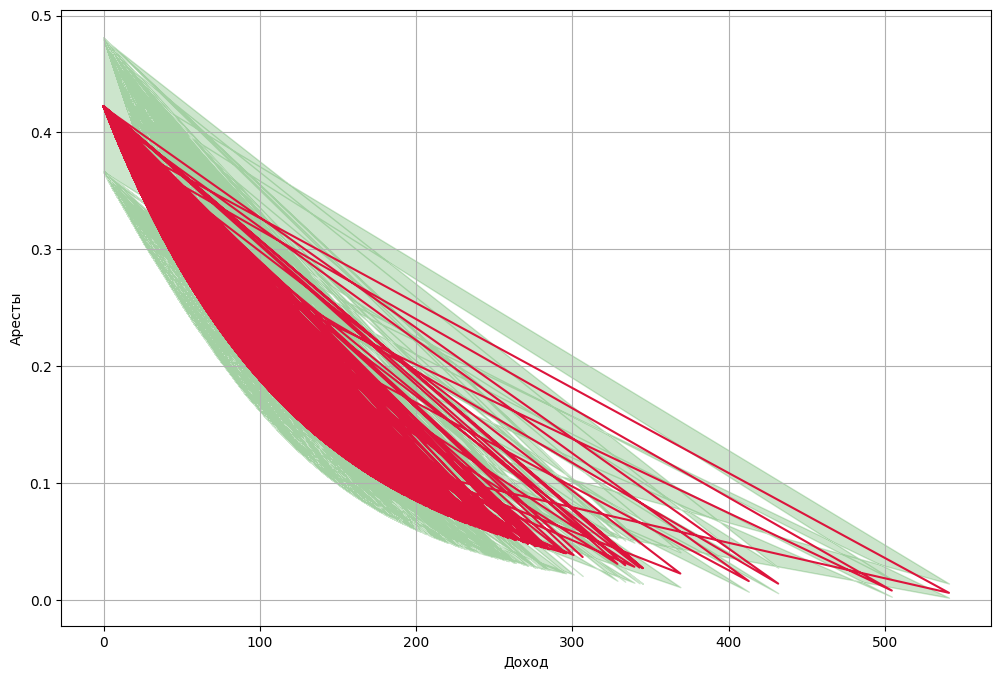

In [ ]:
variance_covariance = results_p.cov_params()
means = results_p.params
coef_distribution = np.random.multivariate_normal(means, variance_covariance, 1000)
binary_variables = ['black', 'hispan', 'born60']
continuous_variables = ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
data_plot = data_estimation[['Intercept', 'pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86', 'inc86', 'black', 'hispan', 'born60']].copy()

for x in binary_variables:
    mean_value = np.mean(data_plot[x])
    if mean_value >=0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in continuous_variables:
    data_plot[x] = np.mean(data_plot[x])

matrix_score = np.exp(np.dot(data_plot, np.transpose(coef_distribution)))
predicted_arrests = np.mean(matrix_score, axis = 1)
upper_bound = np.percentile(matrix_score, axis = 1, q = 97.5)
lower_bound = np.percentile(matrix_score, axis = 1, q = 2.5)

plt.figure(figsize=(12, 8))
plt.plot(data_plot['inc86'], predicted_arrests, color='crimson')
plt.fill_between(data_plot['inc86'], lower_bound, upper_bound, color='green', alpha=0.2) # дов. интервал
plt.xlabel('Доход')
plt.ylabel('Аресты')

plt.grid(True)

plt.show()

##### №3.

In [ ]:
from scipy.special import factorial

In [ ]:

class MyPoisson(GenericLikelihoodModel):
    def loglike(self, params):
        #exog - матрица предикторов (независимых переменных); endog - вектор значений зависимой переменной
        exog = self.exog
        endog = self.endog
        mtt = np.dot(exog, params)
        log_likelihood = np.sum(endog*mtt - np.exp(mtt) - np.log(factorial(endog)))
        return log_likelihood
    
sm_poisson_manual = MyPoisson.from_formula('narr86 ~ pcnv + avgsen + tottime + ptime86 + qemp86 + inc86 + black + hispan + born60',
                                        data = data_estimation).fit(method = 'lbfgs', maxiter = 1000, start_params = [0.01]*10)

print(sm_poisson_manual.summary())

                              MyPoisson Results                               
Dep. Variable:                 narr86   Log-Likelihood:                -2248.8
Model:                      MyPoisson   AIC:                             4518.
Method:            Maximum Likelihood   BIC:                             4577.
Date:                Mon, 03 Mar 2025                                         
Time:                        21:02:38                                         
No. Observations:                2725                                         
Df Residuals:                    2715                                         
Df Model:                           9                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5997      0.067     -8.918      0.000      -0.732      -0.468
pcnv          -0.4017      0.085     -4.727      0.0

##### Результаты едва отличимы от результатов первой модели, что говорит о качестве новой


##### №4.

In [34]:

alldata = data[['Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col10', 'Col11', 'Col12']]
alldata['Intercept'] = [1] * len(data)
alldata.insert(0, alldata.columns[-1], alldata.pop(alldata.columns[-1]))

alldata

C:\Users\fffkn\AppData\Local\Temp\ipykernel_10736\2348023151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Intercept,Col3,Col4,Col5,Col6,Col7,Col8,Col10,Col11,Col12
0,1,0.38,17.6,35.2,12,0.0,0.0,0,0,1
1,1,0.44,0.0,0.0,0,1.0,0.8,0,1,0
2,1,0.33,22.8,22.8,0,0.0,0.0,1,0,1
3,1,0.25,0.0,0.0,5,2.0,8.8,0,1,1
4,1,0.00,0.0,0.0,0,2.0,8.1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2720,1,0.00,0.0,0.0,0,0.0,0.0,0,0,0
2721,1,0.00,0.0,0.0,0,3.0,11.5,0,1,1
2722,1,0.00,0.0,0.0,0,1.0,1.9,0,0,0
2723,1,0.00,0.0,0.0,0,0.0,0.0,1,0,0


In [ ]:
matrix = results_p.cov_params()
means = results_p.params
coeffs = np.random.multivariate_normal(means, matrix, 1000)

X = alldata

derivs = []
for i in range(len(alldata)):
    x = X.iloc[i].values
    for coef in coeffs:
        lp = np.dot(x, coef)
        a = np.exp(lp) * coef[7]
        derivs.append(a)

new_mean = np.mean(derivs)
low = np.percentile(derivs, 2.5)
high = np.percentile(derivs, 97.5)

# print(f'Среднее: {new_mean}')
# print(f'Перцентили: {low}, {high}')

print("Effect Estimate:", new_mean, "****", "Confidence Interval:", [low, high])

Effect Estimate: 0.2673867137486467 **** Confidence Interval: [0.04394892770177749, 0.6814609477890782]


##### Те, у кого бинарная переменная <code>black = 1</code> имеют ожидание арестов, большее на 0.2673

##### №5.

In [40]:
from statsmodels.discrete import count_model

In [ ]:
exog = data_estimation[['Intercept', 'pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86', 'inc86', 'black', 'hispan', 'born60']]
exog_inflation = data_estimation[['Intercept', 'inc86', 'black', 'hispan']]
model = sm.discrete.count_model.ZeroInflatedPoisson(data_estimation['narr86'],
                                                    exog = exog,
                                                    exog_infl = exog_inflation)
results_infl = model.fit(maxiter = 200)
print(results_infl.summary())

Optimization terminated successfully.
         Current function value: 0.806401
         Iterations: 90
         Function evaluations: 104
         Gradient evaluations: 104
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                  narr86   No. Observations:                 2725
Model:             ZeroInflatedPoisson   Df Residuals:                     2715
Method:                            MLE   Df Model:                            9
Date:                 Mon, 03 Mar 2025   Pseudo R-squ.:                 0.06485
Time:                         21:24:15   Log-Likelihood:                -2197.4
converged:                        True   LL-Null:                       -2349.8
Covariance Type:             nonrobust   LLR p-value:                 2.508e-60
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Interc